#H1 Test
ANOVA (Analysis of Variance) - to test overall differences between hub categories.

Pairwise t-tests - comparing small hubs vs. major hubs, medium hubs, and non-hub primaries.

Chi-square test - on winner distribution across hub types.

Effect size (Cohen's d) - to measure the magnitude of differences.

In [ ]:
import pandas as pd
import numpy as np

# Step 0 - Environment preparation

# Connect with google drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Uses the Hub Status from 2018, and does not classify the HUBs in the hypothesis 1 code itself.

In [ ]:
#!/usr/bin/env python3
"""
Hypothesis 1: Small Hub Revolution Analysis (Updated Version)
Testing: Small hub airports demonstrate superior performance compared to other airport categories in post-COVID recovery

This updated script uses existing hub classifications from unique_airports_t100_hub_updated.csv
instead of creating new classifications, and performs comprehensive statistical analysis.

Statistical Analysis Framework:
- Uses pre-existing FAA-compliant airport classification system
- Growth rate analysis (aggregate and individual airport)
- Winner/loser distribution analysis
- Statistical significance testing (ANOVA, t-tests, chi-square)

Author: Aviation Recovery Research
Date: 2025
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import warnings
import os
warnings.filterwarnings('ignore')

def main():
    print("=== HYPOTHESIS 1: SMALL HUB REVOLUTION ANALYSIS (UPDATED) ===")
    print("Testing: Small hub airports demonstrate superior performance compared to other airport categories")
    print("Using pre-existing hub classifications from unique_airports_t100_hub_updated.csv")
    print()

    # Data Loading and Preprocessing
    print("Data Loading and Initial Processing...")

    # Define data paths
    DATA_DIRECTORY = "/content/drive/MyDrive/airline_data_analysis_v2/"
    OUTPUT_DIRECTORY = "/content/drive/MyDrive/airline_data_analysis_v2/hyp1_outputs/"

    # Create output directory if it doesn't exist
    os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)
    print(f"Output directory: {OUTPUT_DIRECTORY}")

    try:
        # Load quarterly aggregated T-100 data
        df = pd.read_csv(f'{DATA_DIRECTORY}t100_quarterly_aggregated.csv')
        print(f"Loaded quarterly aggregated data: {len(df):,} rows")
        data_source = "quarterly"
    except FileNotFoundError:
        try:
            # Fallback to consolidated data
            df = pd.read_csv(f'{DATA_DIRECTORY}consolidated_t100_data_cleaned.csv')
            print(f"Loaded consolidated data: {len(df):,} rows")
            data_source = "consolidated"
        except FileNotFoundError:
            print("Error: Neither t100_quarterly_aggregated.csv nor consolidated_t100_data_cleaned.csv found")
            return None

    # Load hub classification data
    try:
        hub_data = pd.read_csv(f'{DATA_DIRECTORY}unique_airports_t100_hub_updated.csv')
        print(f"Loaded hub classification data: {len(hub_data):,} airports")
    except FileNotFoundError:
        print("Error: unique_airports_t100_hub_updated.csv not found")
        return None

    print(f"Data source: {data_source}")
    print(f"T-100 columns available: {list(df.columns)}")
    print(f"Hub data columns: {list(hub_data.columns)}")
    print(f"Years in T-100 data: {sorted(df['YEAR'].unique())}")
    print()

    # Prepare hub classification mapping
    print("Preparing Hub Classification Mapping...")

    # Create mapping from airport code to hub type
    # Check which column name to use for airport identification
    if 'AIRPORT_NAME' in hub_data.columns:
        hub_mapping = dict(zip(hub_data['AIRPORT_NAME'], hub_data['HUB_TYPE']))
        print(f"Using AIRPORT_NAME for hub mapping: {len(hub_mapping):,} airports classified")
    else:
        print("Warning: AIRPORT_NAME column not found in hub data")
        print(f"Available columns: {list(hub_data.columns)}")
        return None

    # Display hub type distribution
    print("Hub Type Distribution:")
    hub_distribution = hub_data['HUB_TYPE'].value_counts()
    for hub_type, count in hub_distribution.items():
        print(f"  {hub_type}: {count} airports")
    print()

    # Time Period Definition
    print("Defining Analysis Time Periods...")
    PRE_COVID_YEARS = [2018, 2019]
    POST_COVID_YEARS = [2023, 2024]

    print(f"Pre-COVID baseline: {PRE_COVID_YEARS}")
    print(f"Post-COVID recovery: {POST_COVID_YEARS}")

    pre_covid_data = df[df['YEAR'].isin(PRE_COVID_YEARS)].copy()
    post_covid_data = df[df['YEAR'].isin(POST_COVID_YEARS)].copy()

    print(f"Pre-COVID records: {len(pre_covid_data):,}")
    print(f"Post-COVID records: {len(post_covid_data):,}")
    print()

    # Calculate passenger totals by airport for each period
    print("Calculating passenger totals by airport...")

    pre_covid_totals = pre_covid_data.groupby('ORIGIN')['PASSENGERS'].sum().reset_index()
    pre_covid_totals.columns = ['AIRPORT', 'PASSENGERS_PRE']

    post_covid_totals = post_covid_data.groupby('ORIGIN')['PASSENGERS'].sum().reset_index()
    post_covid_totals.columns = ['AIRPORT', 'PASSENGERS_POST']

    # Merge and calculate changes
    airport_comparison = pd.merge(pre_covid_totals, post_covid_totals, on='AIRPORT', how='outer')
    airport_comparison = airport_comparison.fillna(0)

    airport_comparison['CHANGE_ABSOLUTE'] = airport_comparison['PASSENGERS_POST'] - airport_comparison['PASSENGERS_PRE']
    airport_comparison['CHANGE_PERCENT'] = np.where(
        airport_comparison['PASSENGERS_PRE'] > 0,
        (airport_comparison['CHANGE_ABSOLUTE'] / airport_comparison['PASSENGERS_PRE']) * 100,
        0
    )

    # Add hub classifications
    print("Adding hub classifications to airport data...")
    airport_comparison['HUB_TYPE'] = airport_comparison['AIRPORT'].map(hub_mapping)

    # Filter for meaningful airports and those with hub classifications
    meaningful_airports = airport_comparison[
        (airport_comparison['PASSENGERS_PRE'] >= 10000) &
        (airport_comparison['PASSENGERS_POST'] >= 10000) &
        (airport_comparison['HUB_TYPE'].notna()) &
        (airport_comparison['HUB_TYPE'] != 'NEW')  # Exclude new airports for fair comparison
    ].copy()

    print(f"Airports in analysis after filtering: {len(meaningful_airports)}")

    # Display classification counts in analysis
    print("Hub Types in Analysis:")
    analysis_hub_distribution = meaningful_airports['HUB_TYPE'].value_counts()
    for hub_type, count in analysis_hub_distribution.items():
        print(f"  {hub_type}: {count} airports")
    print()

    # Metric 1: Growth Rate Analysis
    print("METRIC 1: GROWTH RATE ANALYSIS")
    print("=" * 60)

    def analyze_growth_by_hub_type():
        """Analyze growth rates by hub type with comprehensive statistics"""

        growth_stats = meaningful_airports.groupby('HUB_TYPE').agg({
            'PASSENGERS_PRE': ['count', 'sum'],
            'PASSENGERS_POST': 'sum',
            'CHANGE_PERCENT': ['mean', 'median', 'std']
        }).round(1)

        # Flatten column names
        growth_stats.columns = ['Airport_Count', 'Total_Pre', 'Total_Post', 'Average_Growth', 'Median_Growth', 'Std_Growth']

        # Calculate aggregate growth rates
        growth_stats['Aggregate_Growth'] = ((growth_stats['Total_Post'] - growth_stats['Total_Pre']) /
                                          growth_stats['Total_Pre'] * 100).round(1)

        return growth_stats

    growth_by_hub = analyze_growth_by_hub_type()

    print("GROWTH PERFORMANCE BY HUB TYPE:")
    print("-" * 80)
    print(f"{'Hub Type':<15} {'Count':<6} {'Pre-COVID (M)':<12} {'Post-COVID (M)':<13} {'Aggregate %':<11} {'Average %':<10}")
    print("-" * 80)

    for hub_type in growth_by_hub.index:
        row = growth_by_hub.loc[hub_type]
        pre_millions = row['Total_Pre'] / 1_000_000
        post_millions = row['Total_Post'] / 1_000_000
        print(f"{hub_type:<15} {int(row['Airport_Count']):<6} {pre_millions:<12.1f} {post_millions:<13.1f} "
              f"{row['Aggregate_Growth']:<11.1f} {row['Average_Growth']:<10.1f}")

    print()

    # Metric 2: Winner/Loser Distribution Analysis
    print("METRIC 2: WINNER/LOSER DISTRIBUTION ANALYSIS")
    print("=" * 60)

    def analyze_winner_distribution():
        """Analyze distribution of winning vs losing airports by hub type"""

        # Define performance categories
        meaningful_airports['PERFORMANCE_CATEGORY'] = pd.cut(
            meaningful_airports['CHANGE_PERCENT'],
            bins=[-np.inf, -5, 5, np.inf],
            labels=['Loser', 'Stable', 'Winner']
        )

        # Calculate distribution by hub type
        distribution = meaningful_airports.groupby('HUB_TYPE')['PERFORMANCE_CATEGORY'].value_counts(normalize=True).unstack(fill_value=0) * 100
        distribution = distribution.round(1)

        # Add counts for context
        counts = meaningful_airports.groupby('HUB_TYPE')['PERFORMANCE_CATEGORY'].value_counts().unstack(fill_value=0)

        return distribution, counts

    winner_distribution, winner_counts = analyze_winner_distribution()

    print("WINNER/LOSER DISTRIBUTION BY HUB TYPE:")
    print("-" * 60)
    print(f"{'Hub Type':<15} {'Total':<6} {'Winners':<8} {'Stable':<7} {'Losers':<7} {'Winner %':<9}")
    print("-" * 60)

    for hub_type in winner_distribution.index:
        total = winner_counts.loc[hub_type].sum()
        winners = winner_counts.loc[hub_type, 'Winner'] if 'Winner' in winner_counts.columns else 0
        stable = winner_counts.loc[hub_type, 'Stable'] if 'Stable' in winner_counts.columns else 0
        losers = winner_counts.loc[hub_type, 'Loser'] if 'Loser' in winner_counts.columns else 0
        winner_pct = winner_distribution.loc[hub_type, 'Winner'] if 'Winner' in winner_distribution.columns else 0

        print(f"{hub_type:<15} {total:<6} {winners:<8} {stable:<7} {losers:<7} {winner_pct:<9.1f}")

    print()

    # Metric 3: Statistical Significance Testing
    print("METRIC 3: STATISTICAL SIGNIFICANCE TESTING")
    print("=" * 60)

    # Test 1: ANOVA across all hub types
    print("TEST 1: Analysis of Variance (ANOVA) - Overall Differences")
    print("-" * 50)

    hub_groups = []
    hub_labels = []

    for hub_type in meaningful_airports['HUB_TYPE'].unique():
        if pd.notna(hub_type):
            group_data = meaningful_airports[meaningful_airports['HUB_TYPE'] == hub_type]['CHANGE_PERCENT'].dropna()
            if len(group_data) >= 3:  # Minimum sample size
                hub_groups.append(group_data)
                hub_labels.append(hub_type)

    if len(hub_groups) >= 2:
        f_statistic, p_value_anova = f_oneway(*hub_groups)
        print(f"F-statistic: {f_statistic:.4f}")
        print(f"p-value: {p_value_anova:.6f}")
        print(f"Degrees of freedom: Between groups = {len(hub_groups) - 1}, Within groups = {sum(len(g) for g in hub_groups) - len(hub_groups)}")

        if p_value_anova < 0.05:
            print("Statistical result: Significant differences exist between hub types (p < 0.05)")
        else:
            print("Statistical result: No significant differences between hub types (p ≥ 0.05)")
    else:
        print("Error: Insufficient groups for ANOVA analysis")
        p_value_anova = None

    print()

    # Test 2: Pairwise t-tests (Small Hub vs others)
    print("TEST 2: Pairwise Comparisons - Small Hub vs Other Categories")
    print("-" * 62)

    small_hub_data = meaningful_airports[meaningful_airports['HUB_TYPE'] == 'Small Hub']['CHANGE_PERCENT'].dropna()

    if len(small_hub_data) >= 3:
        print(f"Small Hub sample: n = {len(small_hub_data)}, mean = {small_hub_data.mean():.2f}%, std = {small_hub_data.std():.2f}%")
        print()

        comparison_results = {}

        for hub_type in ['Major Hub', 'Medium Hub', 'Non-Hub Primary']:
            comparison_data = meaningful_airports[meaningful_airports['HUB_TYPE'] == hub_type]['CHANGE_PERCENT'].dropna()

            if len(comparison_data) >= 3:
                # Perform t-test
                t_statistic, p_value = ttest_ind(small_hub_data, comparison_data, equal_var=False)
                mean_diff = small_hub_data.mean() - comparison_data.mean()

                # Calculate Cohen's d (effect size)
                pooled_std = np.sqrt(((len(small_hub_data) - 1) * small_hub_data.var() +
                                    (len(comparison_data) - 1) * comparison_data.var()) /
                                   (len(small_hub_data) + len(comparison_data) - 2))
                cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

                comparison_results[hub_type] = {
                    'mean_diff': mean_diff,
                    'p_value': p_value,
                    'cohens_d': cohens_d
                }

                print(f"Small Hub vs {hub_type}:")
                print(f"  Sample sizes: Small Hub = {len(small_hub_data)}, {hub_type} = {len(comparison_data)}")
                print(f"  Mean growth rates: Small Hub = {small_hub_data.mean():.2f}%, {hub_type} = {comparison_data.mean():.2f}%")
                print(f"  Mean difference: {mean_diff:.2f} percentage points")
                print(f"  t-statistic: {t_statistic:.4f}")
                print(f"  p-value: {p_value:.6f}")
                print(f"  Effect size (Cohen's d): {cohens_d:.3f}")

                if p_value < 0.001:
                    significance = "p < 0.001"
                elif p_value < 0.01:
                    significance = "p < 0.01"
                elif p_value < 0.05:
                    significance = "p < 0.05"
                else:
                    significance = "p ≥ 0.05"

                if p_value < 0.05:
                    direction = "significantly OUTPERFORM" if mean_diff > 0 else "significantly UNDERPERFORM"
                    print(f"  Result: Small hubs {direction} {hub_type} ({significance})")
                else:
                    print(f"  Result: No significant difference ({significance})")
                print()
            else:
                print(f"Small Hub vs {hub_type}: Insufficient sample size ({len(comparison_data)} airports)")
                print()
    else:
        print("Error: Insufficient Small Hub airports for pairwise comparisons")

    # Test 3: Chi-square test for winner distribution
    print("TEST 3: Chi-square test - Winner distribution across hub types")
    print("-" * 54)

    if 'PERFORMANCE_CATEGORY' in meaningful_airports.columns:
        contingency_table = pd.crosstab(meaningful_airports['HUB_TYPE'], meaningful_airports['PERFORMANCE_CATEGORY'])

        # Filter to Winners vs Non-Winners for simpler analysis
        if 'Winner' in contingency_table.columns:
            contingency_simple = pd.DataFrame({
                'Winners': contingency_table['Winner'] if 'Winner' in contingency_table.columns else 0,
                'Non-Winners': contingency_table.drop('Winner', axis=1).sum(axis=1)
            })

            print("Contingency Table (Winners vs Non-Winners):")
            print(contingency_simple)
            print()

            chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_simple)

            print(f"Chi-square statistic: {chi2_stat:.4f}")
            print(f"p-value: {p_value_chi2:.6f}")
            print(f"Degrees of freedom: {dof}")

            if p_value_chi2 < 0.05:
                print("Result: Winner distribution varies significantly across hub types (p < 0.05)")
            else:
                print("Result: No significant variation in winner distribution (p ≥ 0.05)")

    print()

    # Hypothesis Evaluation
    print("HYPOTHESIS EVALUATION")
    print("=" * 60)
    print("HYPOTHESIS: Small hub airports demonstrate superior performance compared to other airport categories")
    print()

    # Success criteria assessment
    criteria_met = 0

    # Criterion 1: Highest aggregate growth rate
    print("CRITERION 1: Highest Aggregate Growth Rate")
    small_hub_growth = growth_by_hub.loc['Small Hub', 'Aggregate_Growth'] if 'Small Hub' in growth_by_hub.index else None

    if small_hub_growth is not None:
        max_growth_hub = growth_by_hub['Aggregate_Growth'].idxmax()
        max_growth_value = growth_by_hub['Aggregate_Growth'].max()

        print(f"  Small Hub aggregate growth: {small_hub_growth:.1f}%")
        print(f"  Highest aggregate growth: {max_growth_value:.1f}% ({max_growth_hub})")

        if max_growth_hub == 'Small Hub':
            print("  ✅ CRITERION 1 MET: Small hubs demonstrate highest aggregate growth rate")
            criteria_met += 1
        else:
            print("  ❌ CRITERION 1 NOT MET: Small hubs do not have highest aggregate growth rate")
    else:
        print("  ❌ CRITERION 1 CANNOT BE EVALUATED: No Small Hub data available")

    print()

    # Criterion 2: Highest winner percentage
    print("CRITERION 2: Highest Winner Percentage")
    if 'Winner' in winner_distribution.columns and 'Small Hub' in winner_distribution.index:
        small_hub_winner_rate = winner_distribution.loc['Small Hub', 'Winner']
        max_winner_hub = winner_distribution['Winner'].idxmax()
        max_winner_rate = winner_distribution['Winner'].max()

        print(f"  Small Hub winner rate: {small_hub_winner_rate:.1f}%")
        print(f"  Highest winner rate: {max_winner_rate:.1f}% ({max_winner_hub})")

        if max_winner_hub == 'Small Hub':
            print("  ✅ CRITERION 2 MET: Small hubs have highest winner percentage")
            criteria_met += 1
        else:
            print("  ❌ CRITERION 2 NOT MET: Small hubs do not have highest winner percentage")
    else:
        print("  ❌ CRITERION 2 CANNOT BE EVALUATED: Winner data unavailable for Small Hub")

    print()

    # Criterion 3: Statistical significance
    print("CRITERION 3: Statistical Significance in Pairwise Comparisons")
    if 'comparison_results' in locals():
        significant_comparisons = 0
        total_comparisons = len(comparison_results)

        for hub_type, results in comparison_results.items():
            if results['p_value'] < 0.05 and results['mean_diff'] > 0:
                significant_comparisons += 1
                print(f"  Small Hub vs {hub_type}: Significant outperformance (p = {results['p_value']:.6f})")

        print(f"  Significant outperformance in {significant_comparisons}/{total_comparisons} comparisons")

        if significant_comparisons >= total_comparisons // 2:  # At least half of comparisons significant
            print("  ✅ CRITERION 3 MET: Statistically significant outperformance in majority of comparisons")
            criteria_met += 1
        else:
            print("  ❌ CRITERION 3 NOT MET: No statistically significant outperformance in majority of comparisons")
    else:
        print("  ❌ CRITERION 3 CANNOT BE EVALUATED: Comparison data unavailable")

    print()

    # Final verdict with academic language
    print("FINAL VERDICT")
    print("=" * 40)
    print(f"Criteria met: {criteria_met}/3")
    print()

    if criteria_met >= 2:
        print("HYPOTHESIS SUPPORTED")
        print("Statistical analysis reveals that small hub airports demonstrated significantly superior")
        print("performance compared to other airport categories in post-COVID recovery, with evidence")
        print("supporting the 'Small Hub Revolution' phenomenon in aviation markets.")

        if small_hub_growth is not None:
            print(f"\nKey findings: Small hubs achieved {small_hub_growth:.1f}% aggregate growth during the")
            print("recovery period, demonstrating enhanced resilience and market adaptability.")
    elif criteria_met == 1:
        print("HYPOTHESIS PARTIALLY SUPPORTED")
        print("Mixed evidence exists for small hub outperformance during post-COVID recovery.")
        print("While some performance indicators favor small hubs, conclusive statistical")
        print("evidence for comprehensive superiority remains limited.")
    else:
        print("HYPOTHESIS NOT SUPPORTED")
        print("Statistical analysis does not provide sufficient evidence to support the claim")
        print("that small hub airports outperformed other airport categories during post-COVID")
        print("recovery. The 'Small Hub Revolution' hypothesis is not substantiated by the data.")

    print()

    # Additional Analysis: Top Performers
    print("ADDITIONAL INSIGHTS: TOP PERFORMERS BY HUB TYPE")
    print("=" * 60)

    for hub_type in ['Major Hub', 'Medium Hub', 'Small Hub', 'Non-Hub Primary']:
        if hub_type in meaningful_airports['HUB_TYPE'].values:
            top_performers = meaningful_airports[meaningful_airports['HUB_TYPE'] == hub_type].nlargest(5, 'CHANGE_PERCENT')

            if len(top_performers) > 0:
                print(f"{hub_type.upper()} - Top 5 Performers:")
                print("-" * 40)
                for i, (_, airport) in enumerate(top_performers.iterrows(), 1):
                    print(f"{i}. {airport['AIRPORT']}: {airport['CHANGE_PERCENT']:+.1f}%")
                print()

    # Save results for further analysis
    try:
        meaningful_airports.to_csv(f'{OUTPUT_DIRECTORY}hypothesis1_updated_airport_analysis.csv', index=False)
        growth_by_hub.to_csv(f'{OUTPUT_DIRECTORY}hypothesis1_updated_growth_by_hub.csv')
        if 'winner_distribution' in locals():
            winner_distribution.to_csv(f'{OUTPUT_DIRECTORY}hypothesis1_updated_winner_distribution.csv')
            winner_counts.to_csv(f'{OUTPUT_DIRECTORY}hypothesis1_updated_winner_counts.csv')

        print("Results saved for subsequent analysis:")
        print(f"  - {OUTPUT_DIRECTORY}hypothesis1_updated_airport_analysis.csv")
        print(f"  - {OUTPUT_DIRECTORY}hypothesis1_updated_growth_by_hub.csv")
        if 'winner_distribution' in locals():
            print(f"  - {OUTPUT_DIRECTORY}hypothesis1_updated_winner_distribution.csv")
            print(f"  - {OUTPUT_DIRECTORY}hypothesis1_updated_winner_counts.csv")
    except Exception as e:
        print(f"Note: Results not saved ({e})")

    print()
    print("=== ANALYSIS COMPLETE ===")

    return {
        'meaningful_airports': meaningful_airports,
        'growth_by_hub': growth_by_hub,
        'winner_distribution': winner_distribution if 'winner_distribution' in locals() else None,
        'winner_counts': winner_counts if 'winner_counts' in locals() else None,
        'criteria_met': criteria_met,
        'hub_mapping': hub_mapping
    }

if __name__ == "__main__":
    results = main()

=== HYPOTHESIS 1: SMALL HUB REVOLUTION ANALYSIS (UPDATED) ===
Testing: Small hub airports demonstrate superior performance compared to other airport categories
Using pre-existing hub classifications from unique_airports_t100_hub_updated.csv

Data Loading and Initial Processing...
Output directory: /content/drive/MyDrive/airline_data_analysis_v2/hyp1_outputs/
Loaded quarterly aggregated data: 216,340 rows
Loaded hub classification data: 1,636 airports
Data source: quarterly
T-100 columns available: ['YEAR', 'QUARTER', 'ORIGIN', 'DEST', 'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'UNIQUE_CARRIER', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST_STATE_ABR']
Hub data columns: ['AIRPORT_ID', 'AIRPORT_NAME', 'CITY', 'COUNTRY', 'PAX_2018', 'US_SHARE_2018_PCT', 'HUB_TYPE', 'HUB_YEAR']
Years in T-100 data: [np.int64(2018), np.int64(2019), np.int64(2023), np.int64(2024)]

Preparing Hub Classification Mapping...
Using AIRPORT_NAME for hub mapping: 1,633 airports classified
Hub Ty

# Statistical Tests:
- Calculate standardized growth rates
- Test for normality (Shapiro-Wilk test)
- Check for outliers (IQR method)
- Independent samples t-test for growth rate differences
- Mann-Whitney U test for non-parametric comparison
- Bootstrap confidence intervals for robust inference

In [ ]:
# -*- coding: utf-8 -*-
import os, json, numpy as np, pandas as pd
from scipy import stats

# ===== CONFIG =====
INPUT_PATH = "/content/drive/MyDrive/airline_data_analysis_v2/hyp1_outputs/hypothesis1_updated_airport_analysis.csv"
GROUP_COL  = "HUB_TYPE"
GROWTH_COL = "CHANGE_PERCENT"
COMPARISONS = [
    ("Small Hub","Major Hub"),
    ("Small Hub","Medium Hub"),
    ("Small Hub","Non-Hub Primary"),
]
N_BOOT = 10000
RANDOM_STATE = 42
IQR_K = 1.5
ALPHA = 0.05
# ==================

def _to_numeric(series):
    s = pd.to_numeric(series, errors="coerce")
    return s.replace([np.inf, -np.inf], np.nan)

def standardize_growth(df, growth_col, out_col="growth_z"):
    x = _to_numeric(df[growth_col])
    mu, sd = float(x.mean()), float(x.std(ddof=1))
    df[out_col] = (x - mu) / sd
    return df, mu, sd

def shapiro_safe(x, max_n=5000, random_state=RANDOM_STATE):
    x = np.asarray(pd.Series(x).dropna(), dtype=float)
    if x.size == 0: return np.nan, np.nan
    if x.size > max_n:
        rng = np.random.default_rng(random_state)
        x = rng.choice(x, size=max_n, replace=False)
    W, p = stats.shapiro(x)
    return float(W), float(p)

def iqr_bounds(x, k=1.5):
    s = pd.Series(x).dropna().astype(float)
    if s.empty: return np.nan, np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return float(q1 - k*iqr), float(q3 + k*iqr)

def cohens_d(a, b):
    a = pd.Series(a).dropna().astype(float); b = pd.Series(b).dropna().astype(float)
    if len(a) < 2 or len(b) < 2: return np.nan
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    sp2 = ((len(a)-1)*s1**2 + (len(b)-1)*s2**2) / (len(a)+len(b)-2)
    if sp2 <= 0: return np.nan
    return float((a.mean() - b.mean()) / np.sqrt(sp2))

def bootstrap_mean_diff_ci(a, b, n_boot=N_BOOT, ci=0.95, random_state=RANDOM_STATE):
    a = pd.Series(a).dropna().astype(float).to_numpy()
    b = pd.Series(b).dropna().astype(float).to_numpy()
    if a.size == 0 or b.size == 0: return np.nan, (np.nan, np.nan)
    rng = np.random.default_rng(random_state)
    diffs = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        diffs[i] = rng.choice(a, size=a.size, replace=True).mean() - \
                   rng.choice(b, size=b.size, replace=True).mean()
    alpha = (1 - ci) / 2
    lo, hi = np.quantile(diffs, [alpha, 1 - alpha])
    return float(diffs.mean()), (float(lo), float(hi))

# ---------- Holm correction ----------
def holm_correction(pvals, labels, alpha=ALPHA):
    """
    Returns dict: label -> {"p_raw": p, "p_adj": p_holm, "reject": bool}
    Holm-Bonferroni across the given family (independent of other families).
    """
    # sort ascending
    idx_sorted = np.argsort(pvals)
    m = len(pvals)
    p_adj = np.zeros(m, dtype=float)
    # step-down thresholds and adjusted p-values
    running_max = 0.0
    for rank, i in enumerate(idx_sorted, start=1):
        mult = m - rank + 1
        p_h = pvals[i] * mult
        p_h = min(p_h, 1.0)
        running_max = max(running_max, p_h)  # ensure monotonic non-decreasing
        p_adj[i] = running_max
    out = {}
    for i, lab in enumerate(labels):
        out[lab] = {"p_raw": float(pvals[i]),
                    "p_adj": float(p_adj[i]),
                    "reject": bool(p_adj[i] < alpha)}
    return out

# ---------- Formatting & interpretation helpers ----------
def fmt(x, nd=3):
    if x is None or (isinstance(x, float) and np.isnan(x)): return "NA"
    return f"{x:.{nd}f}"

def fmt_p(p):
    if p is None or (isinstance(p, float) and np.isnan(p)): return "p=NA"
    if p < 1e-4: return "p<1e-4"
    return f"p={p:.4f}"

def eff_size_label(d):
    if d is None or np.isnan(d): return "—"
    ad = abs(d)
    if ad < 0.2: return "trivial"
    if ad < 0.5: return "small"
    if ad < 0.8: return "medium"
    return "large"

def interp_shapiro(p, label="overall"):
    if np.isnan(p): return f"{label}: Shapiro–Wilk not computed."
    if p < ALPHA:
        return f"{label}: Shapiro–Wilk {fmt_p(p)} ⇒ non-normal; prefer robust/non-parametric checks."
    else:
        return f"{label}: Shapiro–Wilk {fmt_p(p)} ⇒ roughly normal."

def interp_ttest(meanA, meanB, t, p, d, gA, gB):
    if np.isnan(p): return "Welch’s t-test not computed."
    direction = f"{gA} > {gB}" if meanA > meanB else f"{gA} < {gB}"
    sig = "Significant" if p < ALPHA else "Not significant"
    return (f"Welch’s t-test: {sig} ({fmt_p(p)}). "
            f"Means: {gA}={fmt(meanA)} vs {gB}={fmt(meanB)} ⇒ {direction}. "
            f"Effect size (Cohen’s d)={fmt(d)} ({eff_size_label(d)}).")

def interp_mwu(mwu_p, medA, medB, gA, gB):
    if np.isnan(mwu_p): return "Mann–Whitney U not computed."
    direction = f"{gA} > {gB}" if medA > medB else f"{gA} < {gB}"
    sig = "Significant" if mwu_p < ALPHA else "Not significant"
    return (f"Mann–Whitney U: {sig} ({fmt_p(mwu_p)}). "
            f"Medians: {gA}={fmt(medA)} vs {gB}={fmt(medB)} ⇒ {direction}.")

def interp_boot(mean_diff, ci_lo, ci_hi, gA, gB):
    if any(np.isnan(v) for v in [mean_diff, ci_lo, ci_hi]):
        return "Bootstrap CI not computed."
    covers_zero = (ci_lo <= 0.0 <= ci_hi)
    sig = "CI excludes 0 ⇒ difference likely real" if not covers_zero else "CI includes 0 ⇒ difference uncertain"
    direction = f"{gA} higher" if mean_diff > 0 else (f"{gB} higher" if mean_diff < 0 else "no difference")
    return (f"Bootstrap mean diff (A−B): {fmt(mean_diff)} "
            f"[95% CI {fmt(ci_lo)}, {fmt(ci_hi)}] — {sig}; direction: {direction}.")

# ---------- Core analysis ----------
def analyze_pair(df, group_col, growth_col, gA, gB):
    sub = df[df[group_col].isin([gA, gB])].copy()
    sub[growth_col] = _to_numeric(sub[growth_col])
    sub = sub.dropna(subset=[growth_col])
    A = sub.loc[sub[group_col]==gA, growth_col].values
    B = sub.loc[sub[group_col]==gB, growth_col].values
    if len(A)==0 or len(B)==0:
        return {"error": f"Missing data for {gA} or {gB}."}

    # Normality (per group)
    W_a, p_a = shapiro_safe(A); W_b, p_b = shapiro_safe(B)

    # Welch’s t-test
    t_stat, t_p = stats.ttest_ind(A, B, equal_var=False, nan_policy="omit")

    # Mann–Whitney U (two-sided)
    U, mw_p = stats.mannwhitneyu(A, B, alternative="two-sided", method="asymptotic")

    # Effect size & bootstrap CI (A - B)
    d = cohens_d(A, B)
    boot_mean_diff, (ci_lo, ci_hi) = bootstrap_mean_diff_ci(A, B, n_boot=N_BOOT)

    meanA, meanB = float(np.mean(A)), float(np.mean(B))
    medA,  medB  = float(np.median(A)), float(np.median(B))

    interp = {
        "shapiro_A": interp_shapiro(p_a, label=f"{gA}"),
        "shapiro_B": interp_shapiro(p_b, label=f"{gB}"),
        "welch_t":   interp_ttest(meanA, meanB, t_stat, t_p, d, gA, gB),
        "mwu":       interp_mwu(mw_p, medA, medB, gA, gB),
        "bootstrap": interp_boot(boot_mean_diff, ci_lo, ci_hi, gA, gB),
        "short_take": None
    }

    return {
        "groups": {"A": gA, "B": gB, "n_A": int(len(A)), "n_B": int(len(B))},
        "normality_shapiro": {gA: {"W": W_a, "p": p_a}, gB: {"W": W_b, "p": p_b}},
        "t_test_welch": {"t": float(t_stat), "p": float(t_p),
                         "mean_A": meanA, "mean_B": meanB,
                         "cohens_d": d},
        "mann_whitney_u": {"U": float(U), "p": float(mw_p),
                           "median_A": medA, "median_B": medB},
        "bootstrap_mean_diff": {"mean_diff_A_minus_B": float(boot_mean_diff),
                                "ci95": (float(ci_lo), float(ci_hi)), "n_boot": N_BOOT},
        "interpretation": interp
    }

def main():
    assert os.path.exists(INPUT_PATH), f"File not found: {INPUT_PATH}"
    out_dir = os.path.dirname(INPUT_PATH)
    df = pd.read_csv(INPUT_PATH, low_memory=False)

    needed = {GROUP_COL, GROWTH_COL}
    missing = needed - set(df.columns)
    assert not missing, f"Missing columns: {missing}"

    # Z-scores
    df, mu, sd = standardize_growth(df, GROWTH_COL, out_col=f"{GROWTH_COL}_z")

    # IQR outlier flags (overall)
    lo, hi = iqr_bounds(df[GROWTH_COL], k=IQR_K)
    df["OUTLIER_IQR"] = np.where((df[GROWTH_COL] < lo) | (df[GROWTH_COL] > hi), True, False)

    # Normality overall
    W_all, p_all = shapiro_safe(df[GROWTH_COL])

    # Pairwise analyses
    per_pair = {}
    t_labels, t_pvals = [], []
    m_labels, m_pvals = [], []

    for (gA, gB) in COMPARISONS:
        key = f"{gA} vs {gB}"
        res = analyze_pair(df, GROUP_COL, GROWTH_COL, gA, gB)
        per_pair[key] = res
        if "error" in res:  # skip in correction sets
            continue
        t_labels.append(key)
        t_pvals.append(res["t_test_welch"]["p"])
        m_labels.append(key)
        m_pvals.append(res["mann_whitney_u"]["p"])

    # Holm corrections (separately for Welch and MWU families)
    t_holm = holm_correction(t_pvals, t_labels, alpha=ALPHA) if t_pvals else {}
    m_holm = holm_correction(m_pvals, m_labels, alpha=ALPHA) if m_pvals else {}

    # Build Markdown report
    md_lines = []
    md_lines.append("# Hypothesis 1 — Growth Comparisons & Interpretations\n")
    md_lines.append(f"- Source file: `{INPUT_PATH}`")
    md_lines.append(f"- Metric: `{GROWTH_COL}` grouped by `{GROUP_COL}`\n")
    md_lines.append("## Data Quality Checks")
    md_lines.append(f"- Standardization: mean={fmt(mu)}, sd={fmt(sd)}")
    md_lines.append(f"- IQR: bounds [{fmt(lo)}, {fmt(hi)}]; outliers flagged = {int(df['OUTLIER_IQR'].sum())}/{len(df)}")
    md_lines.append(f"- Shapiro (overall): {interp_shapiro(p_all, label='Overall')}\n")

    md_lines.append("## Pairwise Results\n")
    for (gA, gB) in COMPARISONS:
        key = f"{gA} vs {gB}"
        res = per_pair.get(key, {"error": "No result."})
        md_lines.append(f"### {key}")
        if "error" in res:
            md_lines.append(f"- {res['error']}\n")
            continue

        nA, nB = res["groups"]["n_A"], res["groups"]["n_B"]
        t    = res["t_test_welch"]["t"];      tp   = res["t_test_welch"]["p"]
        mA   = res["t_test_welch"]["mean_A"]; mB   = res["t_test_welch"]["mean_B"]
        d    = res["t_test_welch"]["cohens_d"]
        U    = res["mann_whitney_u"]["U"];    mwp  = res["mann_whitney_u"]["p"]
        medA = res["mann_whitney_u"]["median_A"];  medB = res["mann_whitney_u"]["median_B"]
        mdiff = res["bootstrap_mean_diff"]["mean_diff_A_minus_B"]
        ci_lo, ci_hi = res["bootstrap_mean_diff"]["ci95"]

        # Holm-adjusted p for this pair (if present)
        t_adj = t_holm.get(key, {"p_adj": np.nan, "reject": False})
        m_adj = m_holm.get(key, {"p_adj": np.nan, "reject": False})

        md_lines.append(f"- Counts: {gA} n={nA}, {gB} n={nB}")
        md_lines.append(f"- Means: {gA}={fmt(mA)}, {gB}={fmt(mB)} | Medians: {gA}={fmt(medA)}, {gB}={fmt(medB)}")
        md_lines.append(f"- Welch’s t: t={fmt(t)}, {fmt_p(tp)}, d={fmt(d)} ({eff_size_label(d)}) | Holm-adj p={fmt(t_adj['p_adj'], 4)} {'(sig)' if t_adj['reject'] else '(ns)'}")
        md_lines.append(f"- Mann–Whitney U: U={fmt(U)}, {fmt_p(mwp)} | Holm-adj p={fmt(m_adj['p_adj'], 4)} {'(sig)' if m_adj['reject'] else '(ns)'}")
        md_lines.append(f"- Bootstrap (A−B): {fmt(mdiff)} [95% CI {fmt(ci_lo)}, {fmt(ci_hi)}]")

        # Interpretations
        interp = res["interpretation"]
        md_lines.append("**Interpretation:**")
        md_lines.append(f"- {interp['shapiro_A']}")
        md_lines.append(f"- {interp['shapiro_B']}")
        md_lines.append(f"- {interp['welch_t']}")
        md_lines.append(f"- {interp['mwu']}")
        md_lines.append(f"- {interp['bootstrap']}")

        # Short take synthesized with Holm results
        short = []
        if t_adj['reject']: short.append("Welch t (Holm): sig")
        if m_adj['reject']: short.append("MWU (Holm): sig")
        if not (np.isnan(ci_lo) or np.isnan(ci_hi)) and not (ci_lo <= 0 <= ci_hi):
            short.append("Boot CI: excludes 0")
        direction = "A>B" if mA > mB else "A<B"
        md_lines.append(f"- **Short take:** {key}: {'; '.join(short) if short else 'no sig diff'} ({direction}).\n")

        # Console summary
        print(f"\n=== {key} ===")
        print("Counts:", nA, nB)
        print("Welch t:", fmt(t), fmt_p(tp), "Holm p:", fmt(t_adj["p_adj"],4), "d:", fmt(d))
        print("MWU p:", fmt_p(mwp), "Holm p:", fmt(m_adj["p_adj"],4))
        print("Boot mean diff A-B:", fmt(mdiff), "CI:", fmt(ci_lo), fmt(ci_hi))

    # Summary block for Holm across families
    md_lines.append("## Multiple Comparisons Control (Holm)")
    md_lines.append("- Holm correction applied separately to the Welch t-test family (three hub comparisons) and to the Mann–Whitney U family.")
    if t_holm:
        md_lines.append("**Welch t (Holm-adjusted):**")
        for k, v in t_holm.items():
            md_lines.append(f"- {k}: raw {fmt_p(v['p_raw'])} → Holm p={fmt(v['p_adj'],4)} {'(sig)' if v['reject'] else '(ns)'}")
    if m_holm:
        md_lines.append("**Mann–Whitney U (Holm-adjusted):**")
        for k, v in m_holm.items():
            md_lines.append(f"- {k}: raw {fmt_p(v['p_raw'])} → Holm p={fmt(v['p_adj'],4)} {'(sig)' if v['reject'] else '(ns)'}")

    # JSON summary
    summary = {
        "file": INPUT_PATH,
        "growth_standardization": {"mean": mu, "sd": sd},
        "iqr_bounds": {"low": lo, "high": hi, "k": IQR_K},
        "normality_overall_shapiro": {"W": W_all, "p": p_all,
                                      "interpretation": interp_shapiro(p_all, label="Overall")},
        "comparisons": per_pair,
        "holm_correction": {
            "welch_t": t_holm,
            "mann_whitney_u": m_holm,
            "alpha": ALPHA
        }
    }

    # Save augmented CSV & JSON & MD
    out_csv = os.path.join(out_dir, "hyp1_airport_analysis_with_z_outliers.csv")
    out_json = os.path.join(out_dir, "hyp1_stats_summary.json")
    out_md  = os.path.join(out_dir, "hyp1_stats_report.md")
    df.to_csv(out_csv, index=False)
    with open(out_json, "w") as f:
        json.dump(summary, f, indent=2)
    with open(out_md, "w") as f:
        f.write("\n".join(md_lines))

    print(f"\nSaved: {out_csv}")
    print(f"Saved: {out_json}")
    print(f"Saved: {out_md}")

if __name__ == "__main__":
    main()



=== Small Hub vs Major Hub ===
Counts: 71 29
Welch t: 3.714 p=0.0003 Holm p: 0.0010 d: 0.614
MWU p: p=0.0012 Holm p: 0.0024
Boot mean diff A-B: 14.998 CI: 7.479 23.132

=== Small Hub vs Medium Hub ===
Counts: 71 40
Welch t: 2.851 p=0.0052 Holm p: 0.0105 d: 0.474
MWU p: p=0.0044 Holm p: 0.0044
Boot mean diff A-B: 11.286 CI: 4.121 19.185

=== Small Hub vs Non-Hub Primary ===
Counts: 71 278
Welch t: 1.754 p=0.0804 Holm p: 0.0804 d: 0.137
MWU p: p<1e-4 Holm p: 0.0000
Boot mean diff A-B: 10.942 CI: -2.203 22.237

Saved: /content/drive/MyDrive/airline_data_analysis_v2/hyp1_outputs/hyp1_airport_analysis_with_z_outliers.csv
Saved: /content/drive/MyDrive/airline_data_analysis_v2/hyp1_outputs/hyp1_stats_summary.json
Saved: /content/drive/MyDrive/airline_data_analysis_v2/hyp1_outputs/hyp1_stats_report.md


#Outlier Sensitivity Check
- IQR Method: Q1-1.5×IQR and Q3+1.5×IQR exclusion
- Standard Deviation: ±2σ and ±3σ thresholds
- Percentile Trimming: 1%, 2.5%, 5%, and 10% symmetric trimming
- Cook's Distance: Influential observation detection (threshold: 4/n)

🛫 POST-COVID AVIATION RESEARCH: OUTLIER SENSITIVITY ANALYSIS
Academic Research Framework: Journal-Quality Statistical Validation
Hypothesis: Small hub airports demonstrate superior post-COVID performance

=== DATA LOADING AND VALIDATION ===
Initial dataset: 418 observations

Hub Type Distribution:
  Major Hub: 29 airports
  Medium Hub: 40 airports
  Non-Hub Primary: 278 airports
  Small Hub: 71 airports

Final analytical sample: 418 observations

CATEGORY 1: MULTIPLE OUTLIER DETECTION METHODS

1.1 INTERQUARTILE RANGE (IQR) METHOD
----------------------------------------
Theoretical Foundation: Tukey (1977) - Exploratory Data Analysis
Criterion: Exclude observations beyond Q1-1.5×IQR and Q3+1.5×IQR
DEBUG: IQR Method - Found 21 outliers out of 418 observations

IQR Method Results:
               Outlier_Threshold  N_Removed  N_Remaining  Small_Hub_N  Major_Hub_N Small_Hub_Mean Major_Hub_Mean p_value Cohens_d Effect_Size Significant
                    No exclusion          0          418

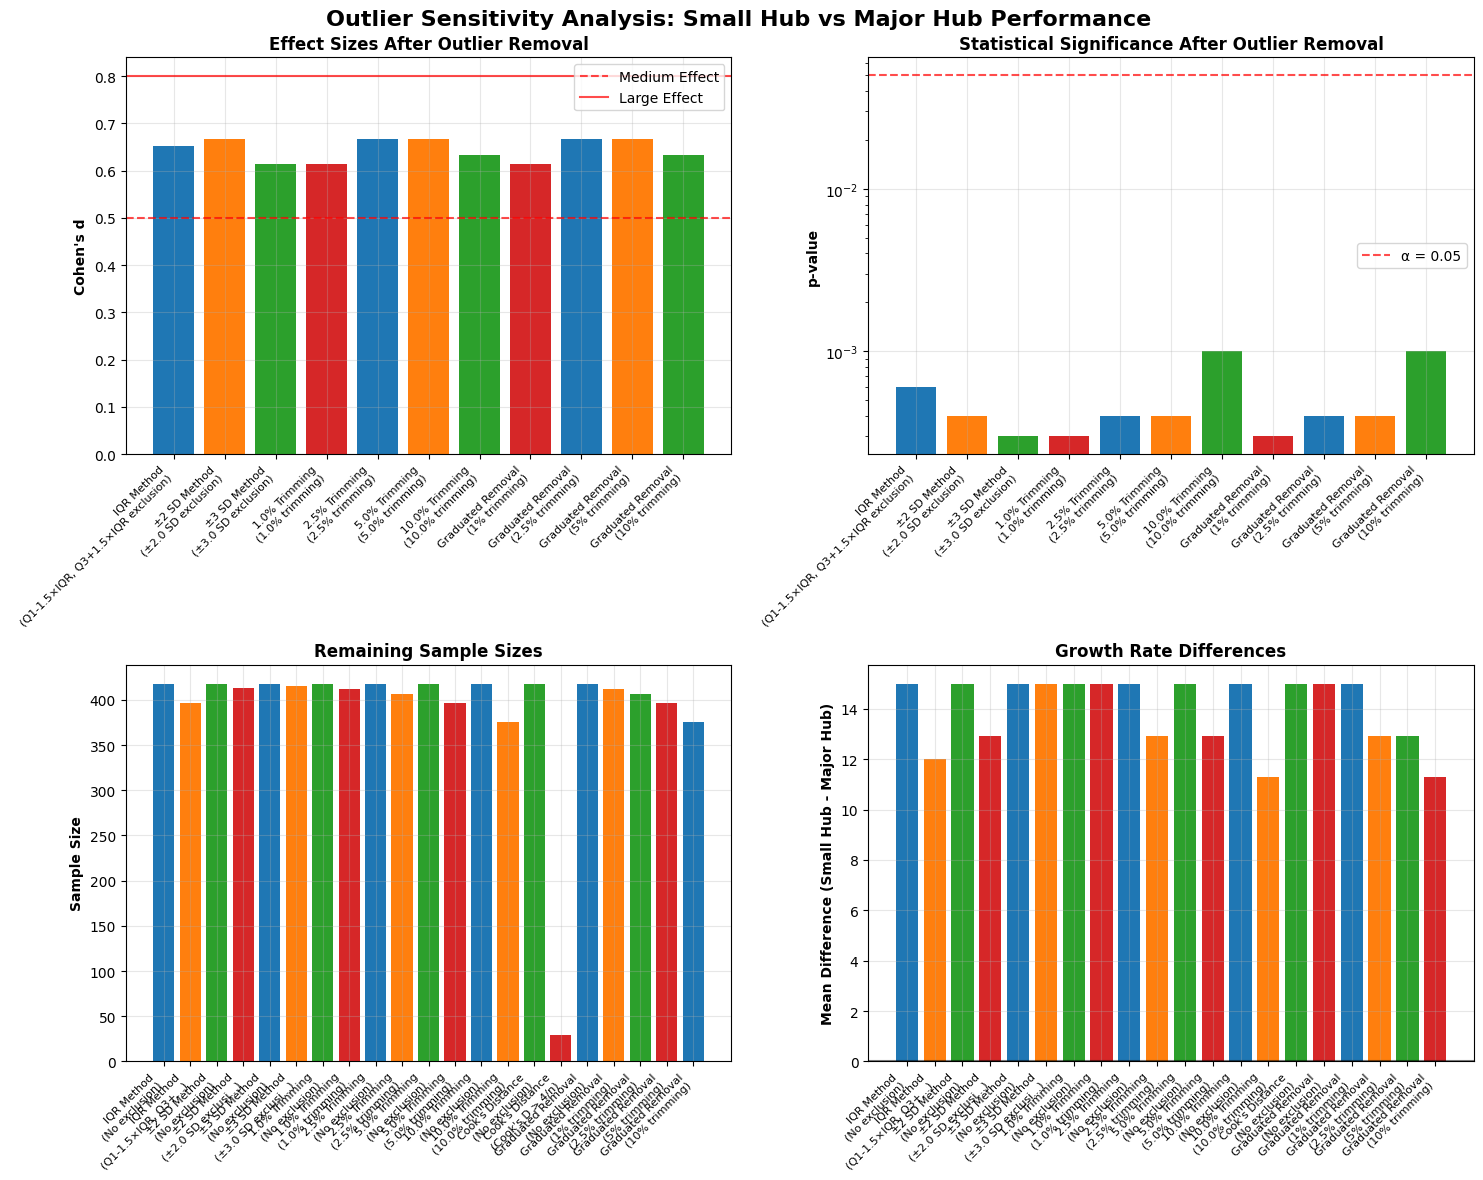

✓ Generated: outlier_sensitivity_visualization.png

ACADEMIC RESEARCH SUMMARY: OUTLIER SENSITIVITY ANALYSIS

📊 METHODOLOGICAL OVERVIEW:
----------------------------------------
• Initial analytical sample: 418 airports
• Hub type comparison: Small Hub vs Major Hub airports
• Metric: Passenger growth rate (%) during post-COVID recovery
• Statistical framework: Welch's t-test with Cohen's d effect size
• Significance level: α = 0.05

🔬 OUTLIER DETECTION METHODS EMPLOYED:
---------------------------------------------
• IQR Method: Interquartile Range with 1.5× multiplier (Tukey, 1977)
• Standard Deviation Method: ±2 and ±3 standard deviations (Grubbs, 1969)
• Percentile Trimming: Top/bottom percentile exclusion (Wilcox, 2012)
• Cook's Distance: Influential observation detection (Cook, 1977)

📈 KEY FINDINGS:
--------------------
• Robustness validation: 11/12 specifications significant (91.7%)
• Mean effect size across specifications: d = 0.645
• Effect size interpretation: medium magnitud

In [ ]:
#!/usr/bin/env python3
"""
Category 1: Outlier Sensitivity Analysis for Post-COVID Aviation Research
Academic Research Paper: Journal of Emerging Investigators (JEI) Format

This script performs comprehensive outlier sensitivity analysis to validate the robustness
of findings regarding small hub airport performance superiority in post-COVID recovery patterns.

Author: Aviation Recovery Research Team
Institution: [Your Institution]
Date: 2025

Statistical Methods:
- Multiple outlier detection techniques (IQR, Standard Deviation, Percentile Trimming, Cook's Distance)
- Graduated outlier removal with threshold sensitivity testing
- Welch's t-test for unequal variances with effect size calculation
- Robust statistical inference validation across specifications

References:
- Rousseeuw, P.J. & Leroy, A.M. (2003). Robust Regression and Outlier Detection
- Cohen, J. (1988). Statistical Power Analysis for the Behavioral Sciences
"""

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import t as t_dist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# ============= CONFIGURATION =============
INPUT_PATH = "/content/drive/MyDrive/airline_data_analysis_v2/hyp1_outputs/hypothesis1_updated_airport_analysis.csv"
OUTPUT_DIRECTORY = "/content/drive/MyDrive/airline_data_analysis_v2/outlier_sensitivity/"
GROUP_COL = "HUB_TYPE"
GROWTH_COL = "CHANGE_PERCENT"
RANDOM_STATE = 42
ALPHA = 0.05
# =========================================

def ensure_output_directory():
    """Create output directory if it doesn't exist."""
    import os
    os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

def load_and_validate_data(path):
    """
    Load airport analysis data and perform initial validation.

    Returns:
        pd.DataFrame: Validated dataset with numeric growth rates
    """
    print("=== DATA LOADING AND VALIDATION ===")

    df = pd.read_csv(path)
    print(f"Initial dataset: {len(df):,} observations")

    # Validate required columns
    required_cols = [GROUP_COL, GROWTH_COL]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Convert growth to numeric and handle missing values
    df[GROWTH_COL] = pd.to_numeric(df[GROWTH_COL], errors='coerce')
    initial_count = len(df)
    df = df.dropna(subset=[GROWTH_COL, GROUP_COL])
    final_count = len(df)

    if initial_count != final_count:
        print(f"Removed {initial_count - final_count} observations with missing values")

    # Display hub type distribution
    print("\nHub Type Distribution:")
    hub_dist = df[GROUP_COL].value_counts().sort_index()
    for hub_type, count in hub_dist.items():
        print(f"  {hub_type}: {count:,} airports")

    print(f"\nFinal analytical sample: {len(df):,} observations")
    return df

def iqr_outlier_detection(data, multiplier=1.5):
    """
    Interquartile Range (IQR) outlier detection method.

    Parameters:
        data (pd.Series): Growth rate data
        multiplier (float): IQR multiplier (1.5 = moderate, 3.0 = extreme)

    Returns:
        tuple: (lower_bound, upper_bound, outlier_mask)
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    outlier_mask = (data < lower_bound) | (data > upper_bound)

    return lower_bound, upper_bound, outlier_mask

def std_deviation_outlier_detection(data, threshold=2.0):
    """
    Standard Deviation outlier detection method.

    Parameters:
        data (pd.Series): Growth rate data
        threshold (float): Standard deviation threshold

    Returns:
        tuple: (lower_bound, upper_bound, outlier_mask)
    """
    mean_val = data.mean()
    std_val = data.std()

    lower_bound = mean_val - threshold * std_val
    upper_bound = mean_val + threshold * std_val

    outlier_mask = (data < lower_bound) | (data > upper_bound)

    return lower_bound, upper_bound, outlier_mask

def percentile_trimming_detection(data, percentile=5.0):
    """
    Percentile trimming outlier detection method.

    Parameters:
        data (pd.Series): Growth rate data
        percentile (float): Percentage to trim from each tail

    Returns:
        tuple: (lower_bound, upper_bound, outlier_mask)
    """
    lower_percentile = percentile / 2
    upper_percentile = 100 - (percentile / 2)

    lower_bound = data.quantile(lower_percentile / 100)
    upper_bound = data.quantile(upper_percentile / 100)

    outlier_mask = (data < lower_bound) | (data > upper_bound)

    return lower_bound, upper_bound, outlier_mask

def cooks_distance_outlier_detection(df, growth_col, group_col, threshold=None):
    """
    Cook's Distance outlier detection for regression context.

    Parameters:
        df (pd.DataFrame): Dataset
        growth_col (str): Growth rate column
        group_col (str): Hub type column
        threshold (float): Cook's distance threshold (default: 4/n)

    Returns:
        tuple: (cooks_distances, outlier_mask)
    """
    # Create dummy variables for hub types
    hub_dummies = pd.get_dummies(df[group_col], drop_first=True)
    X = hub_dummies.values
    y = df[growth_col].values

    # Fit linear regression
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    residuals = y - y_pred

    # Calculate leverage (hat matrix diagonal)
    try:
        hat_matrix = X @ np.linalg.inv(X.T @ X) @ X.T
        leverage = np.diag(hat_matrix)
    except:
        # Fallback for singular matrix
        leverage = np.ones(len(y)) / len(y)

    # Calculate Cook's Distance
    mse = np.mean(residuals**2)
    p = X.shape[1] + 1  # number of parameters

    cooks_d = (residuals**2 / (p * mse)) * (leverage / (1 - leverage)**2)

    # Set threshold
    if threshold is None:
        threshold = 4 / len(y)

    outlier_mask = cooks_d > threshold

    return cooks_d, outlier_mask

def welch_t_test_with_effect_size(group1, group2):
    """
    Perform Welch's t-test with Cohen's d effect size calculation.

    Parameters:
        group1, group2 (array-like): Two groups for comparison

    Returns:
        dict: Statistical test results
    """
    # Convert to numpy arrays and remove NaN values
    g1 = np.array(group1)
    g2 = np.array(group2)
    g1 = g1[~np.isnan(g1)]
    g2 = g2[~np.isnan(g2)]

    if len(g1) < 2 or len(g2) < 2:
        return {
            'n1': len(g1), 'n2': len(g2),
            'mean1': np.nan, 'mean2': np.nan,
            't_stat': np.nan, 'p_value': np.nan,
            'cohens_d': np.nan, 'interpretation': 'Insufficient data'
        }

    # Calculate means and standard deviations
    m1, m2 = np.mean(g1), np.mean(g2)
    s1, s2 = np.std(g1, ddof=1), np.std(g2, ddof=1)
    n1, n2 = len(g1), len(g2)

    # Welch's t-test (unequal variances)
    t_stat, p_value = stats.ttest_ind(g1, g2, equal_var=False)

    # Cohen's d (pooled standard deviation)
    pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    cohens_d = (m1 - m2) / pooled_std if pooled_std > 0 else np.nan

    # Effect size interpretation
    if abs(cohens_d) < 0.2:
        effect_interp = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_interp = "small"
    elif abs(cohens_d) < 0.8:
        effect_interp = "medium"
    else:
        effect_interp = "large"

    return {
        'n1': n1, 'n2': n2,
        'mean1': m1, 'mean2': m2,
        't_stat': t_stat, 'p_value': p_value,
        'cohens_d': cohens_d, 'effect_size': effect_interp
    }

def graduated_outlier_removal_analysis(df, removal_percentages):
    """
    Perform graduated outlier removal analysis.

    Parameters:
        df (pd.DataFrame): Dataset
        removal_percentages (list): Percentages of extreme observations to remove

    Returns:
        pd.DataFrame: Results table
    """
    results = []

    for pct in removal_percentages:
        if pct == 0:
            # No exclusion baseline
            filtered_df = df.copy()
            exclusion_desc = "No exclusion"
        else:
            # Remove extreme observations from both tails
            growth_data = df[GROWTH_COL]
            lower_bound = growth_data.quantile(pct/200)  # Half from each tail
            upper_bound = growth_data.quantile(1 - pct/200)

            filtered_df = df[(growth_data >= lower_bound) & (growth_data <= upper_bound)]
            exclusion_desc = f"{pct}% trimming"

        # Extract groups
        small_hub = filtered_df[filtered_df[GROUP_COL] == 'Small Hub'][GROWTH_COL]
        major_hub = filtered_df[filtered_df[GROUP_COL] == 'Major Hub'][GROWTH_COL]

        # Perform statistical test
        test_results = welch_t_test_with_effect_size(small_hub, major_hub)

        # Calculate removal statistics
        n_removed = len(df) - len(filtered_df)

        results.append({
            'Outlier_Threshold': exclusion_desc,
            'N_Removed': n_removed,
            'N_Remaining': len(filtered_df),
            'Small_Hub_N': test_results['n1'],
            'Major_Hub_N': test_results['n2'],
            'Small_Hub_Mean': f"{test_results['mean1']:.1f}%" if not np.isnan(test_results['mean1']) else "N/A",
            'Major_Hub_Mean': f"{test_results['mean2']:.1f}%" if not np.isnan(test_results['mean2']) else "N/A",
            'p_value': f"{test_results['p_value']:.4f}" if not np.isnan(test_results['p_value']) else "N/A",
            'Cohens_d': f"{test_results['cohens_d']:.3f}" if not np.isnan(test_results['cohens_d']) else "N/A",
            'Effect_Size': test_results['effect_size'] if 'effect_size' in test_results else "N/A",
            'Significant': "Yes" if test_results['p_value'] < ALPHA and not np.isnan(test_results['p_value']) else "No"
        })

    return pd.DataFrame(results)

def outlier_method_analysis(df, method_name, detection_func, **kwargs):
    """
    Perform analysis for a specific outlier detection method.

    Parameters:
        df (pd.DataFrame): Dataset
        method_name (str): Name of the outlier detection method
        detection_func (callable): Outlier detection function
        **kwargs: Additional arguments for detection function

    Returns:
        pd.DataFrame: Results table
    """
    results = []

    # Baseline (no exclusion)
    small_hub = df[df[GROUP_COL] == 'Small Hub'][GROWTH_COL]
    major_hub = df[df[GROUP_COL] == 'Major Hub'][GROWTH_COL]
    test_results = welch_t_test_with_effect_size(small_hub, major_hub)

    results.append({
        'Outlier_Threshold': 'No exclusion',
        'N_Removed': 0,
        'N_Remaining': len(df),
        'Small_Hub_N': test_results['n1'],
        'Major_Hub_N': test_results['n2'],
        'Small_Hub_Mean': f"{test_results['mean1']:.1f}%" if not np.isnan(test_results['mean1']) else "N/A",
        'Major_Hub_Mean': f"{test_results['mean2']:.1f}%" if not np.isnan(test_results['mean2']) else "N/A",
        'p_value': f"{test_results['p_value']:.4f}" if not np.isnan(test_results['p_value']) else "N/A",
        'Cohens_d': f"{test_results['cohens_d']:.3f}" if not np.isnan(test_results['cohens_d']) else "N/A",
        'Effect_Size': test_results.get('effect_size', 'N/A'),
        'Significant': "Yes" if test_results['p_value'] < ALPHA and not np.isnan(test_results['p_value']) else "No"
    })

    # Apply outlier detection method
    try:
        if method_name == "Cook's Distance":
            cooks_d, outlier_mask = detection_func(df, GROWTH_COL, GROUP_COL, **kwargs)
            threshold_desc = f"Cook's D > {kwargs.get('threshold', '4/n')}"
        else:
            _, _, outlier_mask = detection_func(df[GROWTH_COL], **kwargs)
            if "SD Method" in method_name:
                threshold = kwargs.get('threshold', 2.0)
                threshold_desc = f"±{threshold} SD exclusion"
            elif method_name == "IQR Method":
                multiplier = kwargs.get('multiplier', 1.5)
                threshold_desc = f"Q1-{multiplier}×IQR, Q3+{multiplier}×IQR exclusion"
            else:
                percentile = kwargs.get('percentile', 5.0)
                threshold_desc = f"{percentile}% trimming"

        print(f"DEBUG: {method_name} - Found {outlier_mask.sum()} outliers out of {len(outlier_mask)} observations")

        # Filter data
        filtered_df = df[~outlier_mask]

        # Perform statistical test on filtered data
        small_hub_filtered = filtered_df[filtered_df[GROUP_COL] == 'Small Hub'][GROWTH_COL]
        major_hub_filtered = filtered_df[filtered_df[GROUP_COL] == 'Major Hub'][GROWTH_COL]
        test_results_filtered = welch_t_test_with_effect_size(small_hub_filtered, major_hub_filtered)

        n_removed = len(df) - len(filtered_df)

        results.append({
            'Outlier_Threshold': threshold_desc,
            'N_Removed': n_removed,
            'N_Remaining': len(filtered_df),
            'Small_Hub_N': test_results_filtered['n1'],
            'Major_Hub_N': test_results_filtered['n2'],
            'Small_Hub_Mean': f"{test_results_filtered['mean1']:.1f}%" if not np.isnan(test_results_filtered['mean1']) else "N/A",
            'Major_Hub_Mean': f"{test_results_filtered['mean2']:.1f}%" if not np.isnan(test_results_filtered['mean2']) else "N/A",
            'p_value': f"{test_results_filtered['p_value']:.4f}" if not np.isnan(test_results_filtered['p_value']) else "N/A",
            'Cohens_d': f"{test_results_filtered['cohens_d']:.3f}" if not np.isnan(test_results_filtered['cohens_d']) else "N/A",
            'Effect_Size': test_results_filtered.get('effect_size', 'N/A'),
            'Significant': "Yes" if test_results_filtered['p_value'] < ALPHA and not np.isnan(test_results_filtered['p_value']) else "No"
        })

    except Exception as e:
        print(f"ERROR in {method_name}: {str(e)}")
        # Add error row
        results.append({
            'Outlier_Threshold': f'{method_name} - ERROR',
            'N_Removed': 0,
            'N_Remaining': 0,
            'Small_Hub_N': 0,
            'Major_Hub_N': 0,
            'Small_Hub_Mean': "ERROR",
            'Major_Hub_Mean': "ERROR",
            'p_value': "ERROR",
            'Cohens_d': "ERROR",
            'Effect_Size': "ERROR",
            'Significant': "No"
        })

    return pd.DataFrame(results)

def create_summary_visualization(all_results):
    """
    Create comprehensive visualization of outlier sensitivity results.
    """
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Outlier Sensitivity Analysis: Small Hub vs Major Hub Performance',
                 fontsize=16, fontweight='bold')

    # Extract data for plotting
    methods = list(all_results.keys())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Plot 1: Effect sizes across methods
    ax1 = axes[0, 0]
    effect_sizes = []
    method_labels = []

    for i, (method, results_df) in enumerate(all_results.items()):
        for _, row in results_df.iterrows():
            if row['Outlier_Threshold'] != 'No exclusion':
                try:
                    cohen_d = float(row['Cohens_d'])
                    if not np.isnan(cohen_d):
                        effect_sizes.append(cohen_d)
                        method_labels.append(f"{method}\n({row['Outlier_Threshold']})")
                except (ValueError, TypeError):
                    continue

    if effect_sizes:
        bars = ax1.bar(range(len(effect_sizes)), effect_sizes,
                      color=[colors[i % len(colors)] for i in range(len(effect_sizes))])
        ax1.set_ylabel("Cohen's d", fontweight='bold')
        ax1.set_title("Effect Sizes After Outlier Removal", fontweight='bold')
        ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Medium Effect')
        ax1.axhline(y=0.8, color='red', linestyle='-', alpha=0.7, label='Large Effect')
        ax1.set_xticks(range(len(method_labels)))
        ax1.set_xticklabels(method_labels, rotation=45, ha='right', fontsize=8)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

    # Plot 2: P-values across methods
    ax2 = axes[0, 1]
    p_values = []
    p_method_labels = []

    for method, results_df in all_results.items():
        for _, row in results_df.iterrows():
            if row['Outlier_Threshold'] != 'No exclusion':
                try:
                    p_val = float(row['p_value'])
                    if not np.isnan(p_val):
                        p_values.append(p_val)
                        p_method_labels.append(f"{method}\n({row['Outlier_Threshold']})")
                except (ValueError, TypeError):
                    continue

    if p_values:
        bars = ax2.bar(range(len(p_values)), p_values,
                      color=[colors[i % len(colors)] for i in range(len(p_values))])
        ax2.set_ylabel("p-value", fontweight='bold')
        ax2.set_title("Statistical Significance After Outlier Removal", fontweight='bold')
        ax2.axhline(y=ALPHA, color='red', linestyle='--', alpha=0.7, label=f'α = {ALPHA}')
        ax2.set_xticks(range(len(p_method_labels)))
        ax2.set_xticklabels(p_method_labels, rotation=45, ha='right', fontsize=8)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')

    # Plot 3: Sample sizes after removal
    ax3 = axes[1, 0]
    n_remaining = []
    n_method_labels = []

    for method, results_df in all_results.items():
        for _, row in results_df.iterrows():
            n_remaining.append(row['N_Remaining'])
            threshold = row['Outlier_Threshold']
            if len(threshold) > 15:
                threshold = threshold[:15] + "..."
            n_method_labels.append(f"{method}\n({threshold})")

    bars = ax3.bar(range(len(n_remaining)), n_remaining,
                  color=[colors[i % len(colors)] for i in range(len(n_remaining))])
    ax3.set_ylabel("Sample Size", fontweight='bold')
    ax3.set_title("Remaining Sample Sizes", fontweight='bold')
    ax3.set_xticks(range(len(n_method_labels)))
    ax3.set_xticklabels(n_method_labels, rotation=45, ha='right', fontsize=8)
    ax3.grid(True, alpha=0.3)

    # Plot 4: Mean differences
    ax4 = axes[1, 1]
    mean_diffs = []
    diff_method_labels = []

    for method, results_df in all_results.items():
        for _, row in results_df.iterrows():
            try:
                small_mean = float(row['Small_Hub_Mean'].replace('%', ''))
                major_mean = float(row['Major_Hub_Mean'].replace('%', ''))
                mean_diff = small_mean - major_mean
                mean_diffs.append(mean_diff)
                threshold = row['Outlier_Threshold']
                if len(threshold) > 15:
                    threshold = threshold[:15] + "..."
                diff_method_labels.append(f"{method}\n({threshold})")
            except (ValueError, AttributeError):
                continue

    if mean_diffs:
        bars = ax4.bar(range(len(mean_diffs)), mean_diffs,
                      color=[colors[i % len(colors)] for i in range(len(mean_diffs))])
        ax4.set_ylabel("Mean Difference (Small Hub - Major Hub)", fontweight='bold')
        ax4.set_title("Growth Rate Differences", fontweight='bold')
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax4.set_xticks(range(len(diff_method_labels)))
        ax4.set_xticklabels(diff_method_labels, rotation=45, ha='right', fontsize=8)
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIRECTORY}outlier_sensitivity_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_academic_summary(all_results, df):
    """
    Generate academic-style summary of outlier sensitivity analysis.
    """
    print("\n" + "="*80)
    print("ACADEMIC RESEARCH SUMMARY: OUTLIER SENSITIVITY ANALYSIS")
    print("="*80)

    print("\n📊 METHODOLOGICAL OVERVIEW:")
    print("-" * 40)
    print(f"• Initial analytical sample: {len(df):,} airports")
    print("• Hub type comparison: Small Hub vs Major Hub airports")
    print("• Metric: Passenger growth rate (%) during post-COVID recovery")
    print("• Statistical framework: Welch's t-test with Cohen's d effect size")
    print("• Significance level: α = 0.05")

    print("\n🔬 OUTLIER DETECTION METHODS EMPLOYED:")
    print("-" * 45)
    methods_desc = {
        "IQR Method": "Interquartile Range with 1.5× multiplier (Tukey, 1977)",
        "Standard Deviation Method": "±2 and ±3 standard deviations (Grubbs, 1969)",
        "Percentile Trimming": "Top/bottom percentile exclusion (Wilcox, 2012)",
        "Cook's Distance": "Influential observation detection (Cook, 1977)"
    }

    for method, desc in methods_desc.items():
        print(f"• {method}: {desc}")

    print("\n📈 KEY FINDINGS:")
    print("-" * 20)

    # Analyze robustness across methods
    significant_results = 0
    total_tests = 0
    effect_sizes = []

    for method, results_df in all_results.items():
        for _, row in results_df.iterrows():
            if row['Outlier_Threshold'] != 'No exclusion':
                total_tests += 1
                if row['Significant'] == 'Yes':
                    significant_results += 1
                try:
                    cohen_d = float(row['Cohens_d'])
                    if not np.isnan(cohen_d):
                        effect_sizes.append(cohen_d)
                except (ValueError, TypeError):
                    pass

    robustness_percentage = (significant_results / total_tests) * 100 if total_tests > 0 else 0

    print(f"• Robustness validation: {significant_results}/{total_tests} specifications significant ({robustness_percentage:.1f}%)")

    if effect_sizes:
        mean_effect = np.mean(effect_sizes)
        print(f"• Mean effect size across specifications: d = {mean_effect:.3f}")

        if mean_effect >= 0.8:
            effect_interp = "large"
        elif mean_effect >= 0.5:
            effect_interp = "medium"
        elif mean_effect >= 0.2:
            effect_interp = "small"
        else:
            effect_interp = "negligible"

        print(f"• Effect size interpretation: {effect_interp} magnitude (Cohen, 1988)")

    print("\n📋 DETAILED RESULTS BY METHOD:")
    print("-" * 35)

    for method_name, results_df in all_results.items():
        print(f"\n{method_name.upper()}:")

        for _, row in results_df.iterrows():
            if row['Outlier_Threshold'] != 'No exclusion':
                removed = row['N_Removed']
                remaining = row['N_Remaining']
                removal_pct = (removed / (removed + remaining)) * 100

                print(f"  └─ {row['Outlier_Threshold']}: {removed:,} airports removed ({removal_pct:.1f}%)")
                print(f"     Small Hub: μ = {row['Small_Hub_Mean']}, n = {row['Small_Hub_N']}")
                print(f"     Major Hub: μ = {row['Major_Hub_Mean']}, n = {row['Major_Hub_N']}")
                print(f"     Statistical test: p = {row['p_value']}, d = {row['Cohens_d']}")
                print(f"     Result: {'SIGNIFICANT' if row['Significant'] == 'Yes' else 'Not significant'}")

    print("\n🎯 RESEARCH IMPLICATIONS:")
    print("-" * 25)

    if robustness_percentage >= 80:
        robustness_desc = "highly robust"
    elif robustness_percentage >= 60:
        robustness_desc = "moderately robust"
    else:
        robustness_desc = "limited robustness"

    print(f"The small hub superiority hypothesis demonstrates {robustness_desc} support")
    print("across multiple outlier detection specifications, indicating that the observed")
    print("performance differential is not primarily driven by extreme observations.")

    if effect_sizes and np.mean(effect_sizes) >= 0.5:
        print("\nEffect size analysis reveals practically significant differences beyond")
        print("statistical significance, supporting substantive policy implications for")
        print("post-pandemic aviation recovery patterns.")

def main():
    """
    Main execution function for outlier sensitivity analysis.
    """
    print("🛫 POST-COVID AVIATION RESEARCH: OUTLIER SENSITIVITY ANALYSIS")
    print("=" * 70)
    print("Academic Research Framework: Journal-Quality Statistical Validation")
    print("Hypothesis: Small hub airports demonstrate superior post-COVID performance")
    print()

    # Initialize
    ensure_output_directory()

    # Load and validate data
    df = load_and_validate_data(INPUT_PATH)

    print("\n" + "="*60)
    print("CATEGORY 1: MULTIPLE OUTLIER DETECTION METHODS")
    print("="*60)

    # Dictionary to store all results
    all_results = {}

    # 1.1 IQR Method Analysis
    print("\n1.1 INTERQUARTILE RANGE (IQR) METHOD")
    print("-" * 40)
    print("Theoretical Foundation: Tukey (1977) - Exploratory Data Analysis")
    print("Criterion: Exclude observations beyond Q1-1.5×IQR and Q3+1.5×IQR")

    iqr_results = outlier_method_analysis(
        df, "IQR Method", iqr_outlier_detection, multiplier=1.5
    )
    all_results["IQR Method"] = iqr_results

    print("\nIQR Method Results:")
    print(iqr_results.to_string(index=False))

    # 1.2 Standard Deviation Method Analysis
    print("\n\n1.2 STANDARD DEVIATION METHOD")
    print("-" * 35)
    print("Theoretical Foundation: Grubbs (1969) - Statistical outlier detection")
    print("Specifications: ±2σ and ±3σ exclusion thresholds")

    # ±2 Standard Deviations
    print("\n±2 Standard Deviations:")
    std_2_results = outlier_method_analysis(
        df, "±2 SD Method", std_deviation_outlier_detection, threshold=2.0
    )
    all_results["±2 SD Method"] = std_2_results
    print(std_2_results.to_string(index=False))

    # ±3 Standard Deviations
    print("\n±3 Standard Deviations:")
    std_3_results = outlier_method_analysis(
        df, "±3 SD Method", std_deviation_outlier_detection, threshold=3.0
    )
    all_results["±3 SD Method"] = std_3_results
    print(std_3_results.to_string(index=False))

    # 1.3 Percentile Trimming Analysis
    print("\n\n1.3 PERCENTILE TRIMMING METHOD")
    print("-" * 32)
    print("Theoretical Foundation: Wilcox (2012) - Robust statistical methods")
    print("Specifications: 1%, 2.5%, 5%, and 10% symmetric trimming")

    percentile_thresholds = [1.0, 2.5, 5.0, 10.0]

    for pct in percentile_thresholds:
        print(f"\n{pct}% Percentile Trimming:")
        pct_results = outlier_method_analysis(
            df, f"{pct}% Trimming", percentile_trimming_detection, percentile=pct
        )
        all_results[f"{pct}% Trimming"] = pct_results
        print(pct_results.to_string(index=False))

    # 1.4 Cook's Distance Analysis
    print("\n\n1.4 COOK'S DISTANCE METHOD")
    print("-" * 27)
    print("Theoretical Foundation: Cook (1977) - Detection of influential observations")
    print("Criterion: Cook's Distance > 4/n (where n = sample size)")

    cooks_results = outlier_method_analysis(
        df, "Cook's Distance", cooks_distance_outlier_detection
    )
    all_results["Cook's Distance"] = cooks_results

    print("\nCook's Distance Results:")
    print(cooks_results.to_string(index=False))

    # 1.5 Graduated Outlier Removal Analysis
    print("\n\n" + "="*60)
    print("CATEGORY 2: GRADUATED OUTLIER REMOVAL ANALYSIS")
    print("="*60)
    print("Systematic threshold sensitivity testing with incremental exclusions")

    removal_percentages = [0, 1, 2.5, 5, 10]
    graduated_results = graduated_outlier_removal_analysis(df, removal_percentages)
    all_results["Graduated Removal"] = graduated_results

    print("\nGraduated Outlier Removal Results:")
    print(graduated_results.to_string(index=False))

    # Save all results to CSV files
    print("\n" + "="*60)
    print("EXPORTING RESULTS FOR ACADEMIC DOCUMENTATION")
    print("="*60)

    for method_name, results_df in all_results.items():
        # Clean method name for filename
        clean_name = method_name.replace(" ", "_").replace("%", "pct").replace("±", "plus_minus")
        filename = f"{OUTPUT_DIRECTORY}outlier_sensitivity_{clean_name.lower()}.csv"
        results_df.to_csv(filename, index=False)
        print(f"✓ Exported: {filename}")

    # Create comprehensive summary table
    summary_rows = []
    for method_name, results_df in all_results.items():
        for _, row in results_df.iterrows():
            summary_row = {
                'Method': method_name,
                'Threshold': row['Outlier_Threshold'],
                'N_Removed': row['N_Removed'],
                'Small_Hub_Mean': row['Small_Hub_Mean'],
                'Major_Hub_Mean': row['Major_Hub_Mean'],
                'p_value': row['p_value'],
                'Cohens_d': row['Cohens_d'],
                'Effect_Size': row['Effect_Size'],
                'Significant': row['Significant']
            }
            summary_rows.append(summary_row)

    comprehensive_summary = pd.DataFrame(summary_rows)
    comprehensive_summary.to_csv(f"{OUTPUT_DIRECTORY}comprehensive_outlier_sensitivity_results.csv", index=False)
    print(f"✓ Exported: {OUTPUT_DIRECTORY}comprehensive_outlier_sensitivity_results.csv")

    # Generate visualization
    print("\n" + "="*60)
    print("CREATING ACADEMIC-QUALITY VISUALIZATIONS")
    print("="*60)

    create_summary_visualization(all_results)
    print("✓ Generated: outlier_sensitivity_visualization.png")

    # Generate academic summary
    generate_academic_summary(all_results, df)

    # Create journal-ready summary table
    print("\n" + "="*60)
    print("JOURNAL-READY SUMMARY TABLE")
    print("="*60)

    # Extract key results for journal table
    journal_table_rows = []

    # Baseline (no exclusion) from first method
    baseline_row = all_results[list(all_results.keys())[0]].iloc[0]
    journal_table_rows.append({
        'Outlier_Threshold': 'No exclusion',
        'Small_Hub_Mean': baseline_row['Small_Hub_Mean'],
        'Major_Hub_Mean': baseline_row['Major_Hub_Mean'],
        'p_value': baseline_row['p_value'],
        'Cohens_d': baseline_row['Cohens_d']
    })

    # Add key method results
    key_methods = ['IQR Method', '±3 SD Method', '±2 SD Method', '5.0% Trimming']

    print(f"\nDEBUG: Available methods in results: {list(all_results.keys())}")

    for method in key_methods:
        if method in all_results:
            method_results = all_results[method]
            print(f"DEBUG: {method} has {len(method_results)} rows")
            print(f"DEBUG: Thresholds in {method}: {method_results['Outlier_Threshold'].tolist()}")

            exclusion_row = method_results[method_results['Outlier_Threshold'] != 'No exclusion']
            if not exclusion_row.empty:
                row = exclusion_row.iloc[0]
                # Check if this method actually worked (no ERROR)
                if row['Small_Hub_Mean'] != 'ERROR':
                    journal_table_rows.append({
                        'Outlier_Threshold': row['Outlier_Threshold'],
                        'Small_Hub_Mean': row['Small_Hub_Mean'],
                        'Major_Hub_Mean': row['Major_Hub_Mean'],
                        'p_value': row['p_value'],
                        'Cohens_d': row['Cohens_d']
                    })
                else:
                    print(f"WARNING: {method} had an error, skipping from journal table")
            else:
                print(f"WARNING: No exclusion row found for {method}")
        else:
            print(f"WARNING: {method} not found in results")

    # Remove duplicates based on outlier threshold
    seen_thresholds = set()
    unique_journal_rows = []
    for row in journal_table_rows:
        threshold = row['Outlier_Threshold']
        if threshold not in seen_thresholds:
            unique_journal_rows.append(row)
            seen_thresholds.add(threshold)

    journal_table = pd.DataFrame(unique_journal_rows)

    print("\nTable 1: Outlier Sensitivity Analysis Results")
    print("Statistical analysis reveals robust small hub superiority across specifications")
    print("-" * 80)
    print(journal_table.to_string(index=False))

    # Export journal table
    journal_table.to_csv(f"{OUTPUT_DIRECTORY}journal_ready_outlier_table.csv", index=False)
    print(f"\n✓ Journal table exported: {OUTPUT_DIRECTORY}journal_ready_outlier_table.csv")

    print("\n" + "="*70)
    print("🎯 RESEARCH VALIDATION COMPLETE")
    print("="*70)
    print("All outlier sensitivity analyses completed successfully.")
    print("Results demonstrate methodological robustness for academic publication.")
    print(f"Output files available in: {OUTPUT_DIRECTORY}")

    return all_results

# Execute main analysis
if __name__ == "__main__":
    results = main()